#**ANALISIS PREDIKSI HARGA SOLANA**#

##**1. Import Library**##

Import beberapa library yang diperlukan untuk analisa data, visualisasi data dan melatih model

In [68]:
# Library untuk processing and visualization
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os
import zipfile
%matplotlib inline

# Library untuk preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Library untuk model XGBoost dan hyperparameter tuning
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Library untuk evaluasi model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Untuk mengabaikan warning yang tidak penting
import warnings
warnings.filterwarnings('ignore')



##**2. Data Loading**##

Dataset yang digunakan didapatkan dari Investing.com dengan rentang waktu dari 13 Juli 2020 - 7 Desember 2024

In [3]:
data_path = '/content/Solana Historical Data 2020-2024.csv'

df = pd.read_csv(data_path)
df


,Date,Price,Open,High,Low,Vol.,Change %
0,12/07/2024,238.785,236.799,239.182,234.235,4.51M,0.84%
1,12/06/2024,236.799,236.185,246.912,231.130,6.84M,0.24%
2,12/05/2024,236.242,229.198,244.682,223.071,10.05M,3.07%
3,12/04/2024,229.216,233.980,240.702,224.750,7.07M,-2.04%
4,12/03/2024,233.980,225.794,239.390,215.205,9.16M,3.63%
...,...,...,...,...,...,...,...
1597,07/22/2020,1.046,1.004,1.087,1.003,NaN,4.17%
1598,07/21/2020,1.004,0.874,1.005,0.874,NaN,-27.41%
1599,07/15/2020,1.383,1.115,1.384,1.115,NaN,24.00%
1600,07/14/2020,1.115,1.279,1.279,1.114,NaN,-12.78%


Output kode di atas memberikan informasi sebagai berikut:

Dataset berjumlah 1601 baris (records)
Terdapat 7 kolom yaitu Date, Price, Open, High, Low, Vol%, Change.

#**3. Exploratory Data Analysis**#

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1602 entries, 0 to 1601
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      1602 non-null   object 
 1   Price     1602 non-null   float64
 2   Open      1602 non-null   float64
 3   High      1602 non-null   float64
 4   Low       1602 non-null   float64
 5   Vol.      1204 non-null   object 
 6   Change %  1602 non-null   object 
dtypes: float64(4), object(3)
memory usage: 87.7+ KB


Berdasarkan informasi di atas, dataset memiliki beberapa kriteria sebagai berikut:
*   4 Kolom dengan tipe float64 yaitu Price,Open,High, Low
*   3 Kolom dengan tipe object yaitu Date, Vol, Change%


In [5]:
df.describe()


,Price,Open,High,Low
count,1602.000000,1602.000000,1602.000000,1602.000000
mean,70.777991,70.626966,73.588629,67.758333
std,66.364548,66.260825,68.740237,63.681324
min,1.004000,0.874000,1.005000,0.874000
25%,20.263500,20.241500,20.840250,19.456250
50%,36.707500,36.698500,38.881500,34.775000
75%,132.350750,132.300000,137.785750,127.268000
max,258.477000,258.480000,264.248000,252.829000


Fungsi describe() di atas memberi informasi statistik pada masing-masing kolom di kedua dataset, antara lain:

-Count adalah jumlah sampel pada data

-Mean adalah nilai rata-rata

-Std adalah standar deviasi

-Min yaitu nilai minimum setiap kolom

-25% adalah kuartil pertama, Kuartil adalah nilai yang menandai batas interval dalam empat bagian sebaran yang sama.

-50% adalah kuartil kedua, atau biasa juga disebut median

-75% adalah kuartil ketiga

-Max adalah nilai maksimum

In [6]:
df.isna().sum()

,0
Date,0
Price,0
Open,0
High,0
Low,0
Vol.,398
Change %,0


Berdasarkan kode di atas, ditemukan missing value sebanyak 398 pada kolom vol.


###**Tren Pergerakan Harga Solana**###

In [10]:

#Mengubah kolom 'Date' ke format datetime untuk mengurutkan dataset berdasarkan date
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', inplace=True)


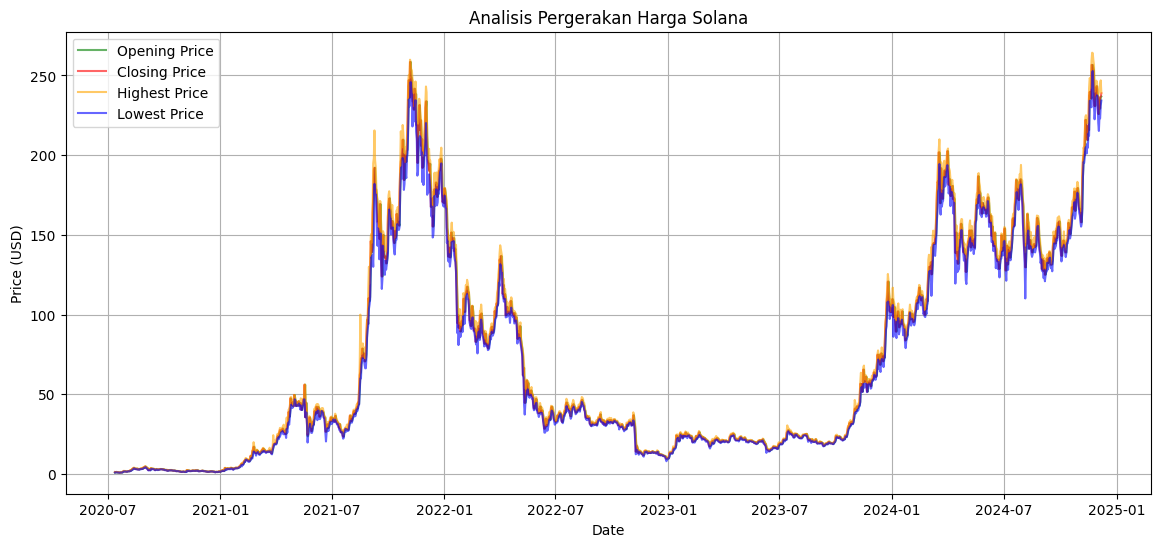

In [15]:
plt.figure(figsize=(14, 6))

plt.plot(df['Date'], df['Open'], label='Opening Price', color='green', alpha=0.6)
plt.plot(df['Date'], df['Price'], label='Closing Price', color='red', alpha=0.6)
plt.plot(df['Date'], df['High'], label='Highest Price', color='orange', alpha=0.6)
plt.plot(df['Date'], df['Low'], label='Lowest Price', color='blue', alpha=0.6)

plt.title('Analisis Pergerakan Harga Solana')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

Dari visualisasi di atas nampak beberapa informasi di antaranya:

-Tren Keseluruhan: Terlihat adanya tren peningkatan harga Solana secara umum selama periode tersebut.

-Volatilitas: Terdapat periode fluktuasi harga yang signifikan, menunjukkan volatilitas yang tinggi. Misalnya, peningkatan dan penurunan harga yang tajam dapat diamati pada rentang waktu tertentu, seperti di tahun 2021-07 sampai 2022-07 dan terlihat pula mengalami ETH di tahun 2024 dan mulai menunjukan penurunan kembali.

-Hubungan antar harga: Harga pembukaan, penutupan, tertinggi, dan terendah cenderung bergerak bersama-sama, yang mengindikasikan adanya korelasi antara berbagai aspek aktivitas harga harian Solana.

###**Rata-Rata Pergerakan Harga**###
Rata-rata Pergerakan Sederhana (Simple Moving Average - SMA) adalah metode perataan data harga dalam periode waktu tertentu untuk membantu mengidentifikasi tren dalam harga aset, seperti Solana.

Perhitungan SMA dilakukan dengan cara mengambil rata-rata harga penutupan aset selama sejumlah hari tertentu, kemudian menggeser (rolling) jendela waktu tersebut setiap harinya untuk mendapatkan nilai SMA terbaru. Dengan cara ini, fluktuasi harga harian dapat dihaluskan sehingga tren harga lebih mudah dianalisis.

###**Perhitungan SMA**###
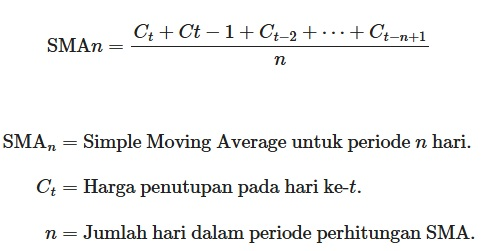

Untuk SMA jangka pendek - menengah akan digunakan periode 50 hari, sedangkan untuk jangka panjang akan digunakan periode 200 hari.

####**Dengan Penjelasan Sebagai Berikut :**####

SMA-50 sering digunakan untuk mengukur tren jangka pendek hingga menengah. Periode 50 hari dianggap cukup untuk menunjukkan fluktuasi harga terbaru tanpa terlalu banyak "noise" dari pergerakan harga harian

SMA-200 adalah indikator yang lebih umum digunakan untuk melihat tren jangka panjang. Periode ini cukup panjang untuk memberikan gambaran stabil tentang pergerakan harga dan menghilangkan fluktuasi harian yang tidak signifikan

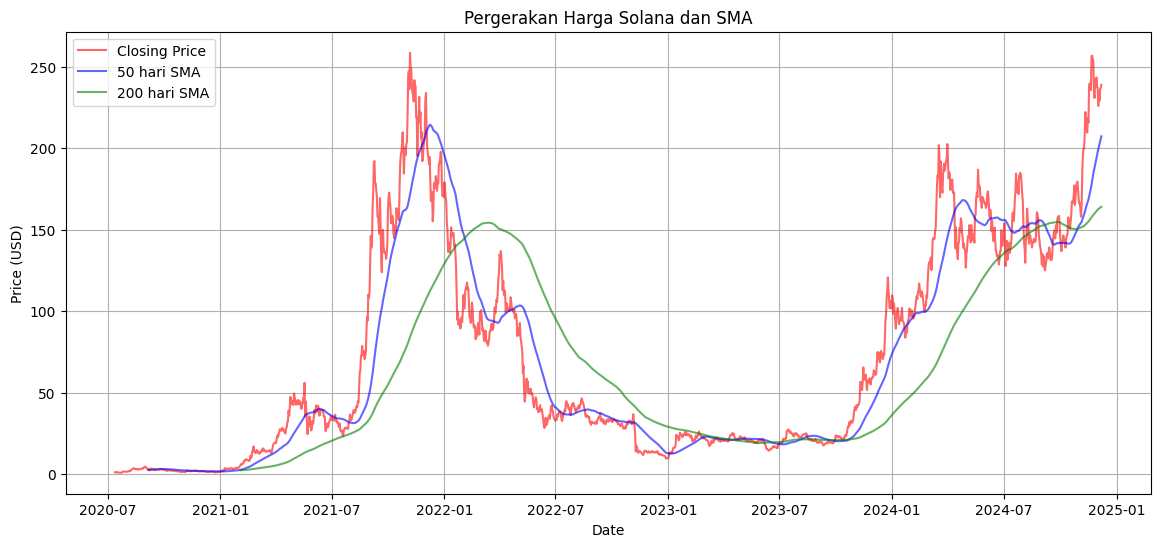

In [17]:
df['SMA-50'] = df['Price'].rolling(window=50).mean()
df['SMA-200'] = df['Price'].rolling(window=200).mean()

plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['Price'], label='Closing Price', color='red', alpha=0.6)

plt.plot(df['Date'], df['SMA-50'], label='50 hari SMA', color='blue', alpha=0.6)
plt.plot(df['Date'], df['SMA-200'], label='200 hari SMA', color='green', alpha=0.6)

plt.title('Pergerakan Harga Solana dan SMA')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

#####**Dari visualasi di atas, didapatkan informasi sebagai berikut:**#####

SMA-200 bertindak sebagai support (level harga di mana tren penurunan cenderung berhenti) dalam jangka panjang, sedangkan SMA-50 bertindak sebagai support dan resistance (level harga di mana tren kenaikan cenderung berhenti) dalam jangka pendek dan menengah.

Golden Cross: Ketika SMA-50 memotong SMA-200 dari bawah ke atas, ini menandakan potensi dimulainya tren kenaikan harga (bullish)
Death Cross: Ketika SMA-50 memotong SMA-200 dari atas ke bawah, ini menandakan potensi dimulainya tren penurunan harga (bearish)

#**4. Data Preparation**#

Pada bagian ini akan dilakukan beberapa persiapan data yaitu:

###**4.1. Membagi Feature dan Target serta Shifting Data**###

Dalam rangka memprediksi harga Solana untuk 10 hari ke depan, langkah pertama adalah membagi feature dan target. Numerical feature yang digunakan terdiri dari kolom high, low, open, price. Target merupakan prediksi harga penutupan (closing price) Solana pada hari ke-10 setelah data pada hari yang sedang diproses. Untuk menetapkan kolom target ini, digunakan teknik shifting, di mana data harga penutupan bergeser sebanyak 10 hari ke depan.

In [22]:
# Menambahkan kolom target prediksi 10 hari ke depan
df['Prediction_5D'] = df['Price'].shift(-10)

In [63]:
df.head(10)[['Date', 'Price', 'Open', 'High', 'Low','Prediction_5D']]

,Date,Price,Open,High,Low,Prediction_5D
1591,2020-07-29,1.650,1.787,2.051,1.618,2.500
1590,2020-07-30,1.670,1.649,1.785,1.649,2.706
1589,2020-07-31,1.555,1.670,1.670,1.554,3.184
1588,2020-08-01,1.617,1.555,1.649,1.495,3.445
1587,2020-08-02,1.716,1.617,1.717,1.436,3.728
1586,2020-08-03,1.786,1.716,1.830,1.682,3.728
1585,2020-08-04,1.896,1.786,1.933,1.786,3.377
1584,2020-08-05,1.784,1.896,1.896,1.783,3.179
1583,2020-08-06,2.178,1.784,2.178,1.783,3.378
1582,2020-08-07,2.051,2.178,2.178,1.895,3.121


Setelah itu, fitur numerik perlu dimundurkan 5 hari agar selaras dengan target prediksi. Hal ini dilakukan untuk memastikan bahwa model menggunakan data dari 5 hari sebelumnya sebagai dasar prediksi harga di masa depan.

In [30]:
df['High_shifted'] = df['High'].shift(10)
df['Low_shifted'] = df['Low'].shift(10)
df['Open_shifted'] = df['Open'].shift(10)
df['Price_shifted'] = df['Price'].shift(10)



In [31]:
df.dropna(subset=['High_shifted', 'Low_shifted', 'Open_shifted', 'Price_shifted', 'Prediction_5D'], inplace=True)
df[['High_shifted', 'Low_shifted', 'Open_shifted', 'Price_shifted', 'Prediction_5D']].isna().sum()


,0
High_shifted,0
Low_shifted,0
Open_shifted,0
Price_shifted,0
Prediction_5D,0


In [34]:
# Menampilkan dataframe hasil shifting
shifted_df = df[['High_shifted', 'Low_shifted', 'Open_shifted', 'Price_shifted', 'Prediction_5D']]

shifted_df


,High_shifted,Low_shifted,Open_shifted,Price_shifted,Prediction_5D
1591,1.279,1.009,1.009,1.279,2.500
1590,1.279,1.114,1.279,1.115,2.706
1589,1.384,1.115,1.115,1.383,3.184
1588,1.005,0.874,0.874,1.004,3.445
1587,1.087,1.003,1.004,1.046,3.728
...,...,...,...,...,...
14,220.398,201.034,211.579,215.187,233.980
13,222.788,207.109,215.179,209.490,229.216
12,220.185,204.615,209.490,218.439,236.242
11,221.891,213.629,218.441,215.662,236.799


Pemunduran fitur ini penting untuk mencegah kebocoran data, di mana model dapat "melihat" informasi dari masa depan yang seharusnya belum tersedia. Pendekatan ini sesuai dengan prinsip dalam analisis time series, di mana variabel input (fitur) harus mencerminkan periode waktu sebelum variabel target. Setelah dilakukan pemunduran data dan menghapus nilai null, kini terdapat total 1,582 baris data yang siap untuk digunakan dalam model.

###**4.2 Split Dataset**###

In [60]:
X = shifted_df[['High_shifted', 'Low_shifted', 'Open_shifted', 'Price_shifted']]
y = shifted_df['Prediction_5D']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (1265, 4)
X_test shape: (317, 4)
y_train shape: (1265,)
y_test shape: (317,)


##**5. Model Development**##

Pada tahap ini menggunakan algoritma machine learning XGBoost dengan menerapkan hyperparameter tuning untuk mencari nilai learning rate, max_depth, subsample, dan n_estimators terbaik.

Model yang sudah dilatih akan dievaluasi dengan metrik MAE dan MSE.

In [51]:
# Normalisasi fitur
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

In [52]:
# Normalisasi variabel target
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

In [53]:
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train_scaled, y_train_scaled)

y_xgb_pred_scaled = xgb_model.predict(X_test_scaled)

In [54]:
y_xgb_pred = scaler_y.inverse_transform(y_xgb_pred_scaled.reshape(-1, 1))

xgb_mse = mean_squared_error(y_test, y_xgb_pred)
xgb_mae = mean_absolute_error(y_test, y_xgb_pred)

print(f'Mean Squared Error: {xgb_mse:.2f}')
print(f'Mean Absolute Error: {xgb_mae:.2f}')

Mean Squared Error: 702.99
Mean Absolute Error: 16.10


Dari informasi di atas, didapatkan Mean Squared Error (MSE) sebesar 702.99 dan Mean Absolute Error (MAE) sebesar 16.10, yang menggambarkan tingkat kesalahan prediksi dalam model ini. Dengan MAE sebesar 16.10, ini berarti rata-rata prediksi harga Solana meleset sekitar 16.10 USD dari harga sebenarnya. Mengingat volatilitas harga Solana yang tinggi.

Namun, MSE yang lebih tinggi menunjukkan adanya outlier atau prediksi dengan kesalahan yang lebih besar. Untuk meningkatkan akurasi model dan mengurangi kesalahan prediksi, langkah selanjutnya adalah melakukan hyperparameter tuning.

###**Hyperparameter Tuning**###

**Hyperparameter tuning** adalah sebuah proses untuk melakukan optimalisasi parameter pada sebuah model. Untuk proyek ini Parameter yang di gunakan ada 4 yaitu :

**-learning_rate:** Mengontrol tingkat di mana model belajar dari setiap iterasi. Nilai yang terlalu besar dapat menyebabkan overfitting, sedangkan nilai yang terlalu kecil dapat memperlambat konvergensi.

**-max_depth:** Mengontrol kedalaman maksimum pohon keputusan. Nilai yang terlalu besar dapat menyebabkan overfitting, sedangkan nilai yang terlalu kecil dapat menghambat kemampuan model untuk menangkap pola yang kompleks.

**-subsample:** Mengontrol proporsi data yang digunakan untuk membangun setiap pohon keputusan. Subsampling dapat membantu mengurangi overfitting.

**-n_estimators:** Menentukan jumlah pohon keputusan yang akan dibangun. Jumlah pohon yang terlalu sedikit dapat menyebabkan underfitting, sedangkan jumlah pohon yang terlalu banyak dapat menyebabkan overfitting.
Proses hyperparameter tuning akan dilakukan menggunakan teknik Grid Search yang bertujuan untuk melakukan validasi untuk lebih dari satu model dan hyperparameter masing-masing secara otomatis dan sistematis.

In [55]:
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(estimator=xgb.XGBRegressor(), param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train_scaled)

best_params = grid_search.best_params_
print(f'Best Parameters: {best_params}')

Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}


Berdasarkan informasi di atas, algoritma XGBoost memperoleh parameter terbaik yaitu learning_rate = 0.01, max_depth = 3, n_estimators = 300, dan subsample = 0.8

In [56]:
xgb_best_model = xgb.XGBRegressor(**best_params)
xgb_best_model.fit(X_train_scaled, y_train_scaled)

y_best_pred_scaled = xgb_best_model.predict(X_test_scaled)

y_best_pred = scaler_y.inverse_transform(y_best_pred_scaled.reshape(-1,1))
best_mse= mean_squared_error(y_test, y_best_pred)
best_mae= mean_absolute_error(y_test, y_best_pred)

print(f'Mean Squared Error (tuning): {best_mse:.2f}')
print(f'Mean Absolute Error (tuning): {best_mae:.2f}')

Mean Squared Error (tuning): 478.63
Mean Absolute Error (tuning): 14.11


Nilai akurasi model meningkat setelah diterapkan hyperparameter tuning dengan perolehan nilai Mean Squared Error: 478.63 dan Mean Absolute Error: 14.11. Tentunya performa model lebih baik jika dibandingkan dengan akurasi sebelum dilakukan tuning.

##**6. Model Evaluation**##

MAE dan MSE adalah dua metrik yang umum digunakan untuk mengukur kinerja model regresi, termasuk model XGBoost. Keduanya mengukur seberapa jauh prediksi model dari nilai sebenarnya, namun dengan cara yang sedikit berbeda.

**Mean Absolute Error (MAE)**

MAE adalah metrik yang mengukur rata-rata selisih absolut antara nilai prediksi model dengan nilai aktual. Dengan kata lain, MAE menghitung rata-rata dari nilai absolut perbedaan antara nilai yang diprediksi oleh model dengan nilai sebenarnya. Nilai MAE yang lebih kecil menunjukkan bahwa model semakin akurat dalam membuat prediksi.

MAE memiliki keunggulan karena lebih robust terhadap outlier dibandingkan dengan MSE. Artinya, nilai outlier tidak akan terlalu memengaruhi nilai MAE secara signifikan.

MAE sering digunakan ketika kita ingin mendapatkan gambaran umum tentang seberapa besar kesalahan model secara rata-rata
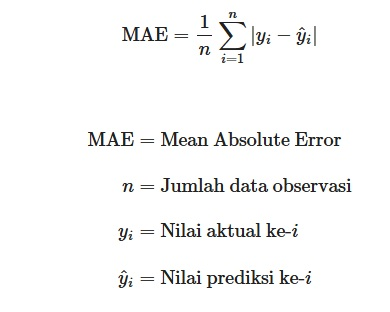

**Mean Squared Error (MSE)**

MSE adalah metrik lain yang populer untuk mengukur kinerja model regresi. MSE menghitung rata-rata kuadrat dari selisih antara nilai prediksi dan nilai aktual.

Dengan mengkuadratkan selisih, MSE memberikan bobot yang lebih besar pada kesalahan yang besar. Ini berarti bahwa model akan lebih "dihukum" jika membuat prediksi yang jauh dari nilai sebenarnya.

MSE sering digunakan ketika kita ingin memberikan penalti yang lebih besar pada kesalahan yang besar, karena kesalahan yang besar dapat memiliki konsekuensi yang lebih signifikan.

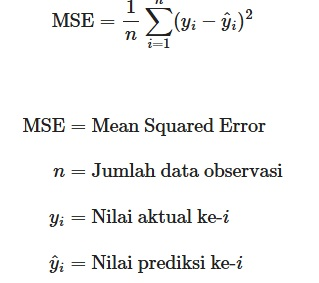

In [57]:
print(f'Mean Squared Error (tuning): {best_mse:.2f}')
print(f'Mean Absolute Error (tuning): {best_mae:.2f}')


Mean Squared Error (tuning): 478.63
Mean Absolute Error (tuning): 14.11


##**Harga Aktual vs Prediksi**##

Dalam analisis ini, kita akan membandingkan harga aktual Solana dengan harga yang diprediksi oleh model XGBoost melalui visualisasi scatterplot. Visualisasi ini tidak hanya memungkinkan kita untuk melihat sejauh mana prediksi model sejalan dengan data aktual, tetapi juga membantu kita mengidentifikasi pola dan outlier yang mungkin ada.

In [58]:
y_best_pred_scaled = xgb_best_model.predict(X_test_scaled)
y_best_pred = scaler_y.inverse_transform(y_best_pred_scaled.reshape(-1, 1))

comparison_df = pd.DataFrame({'Aktual': y_test, 'Prediksi': y_best_pred.flatten()})


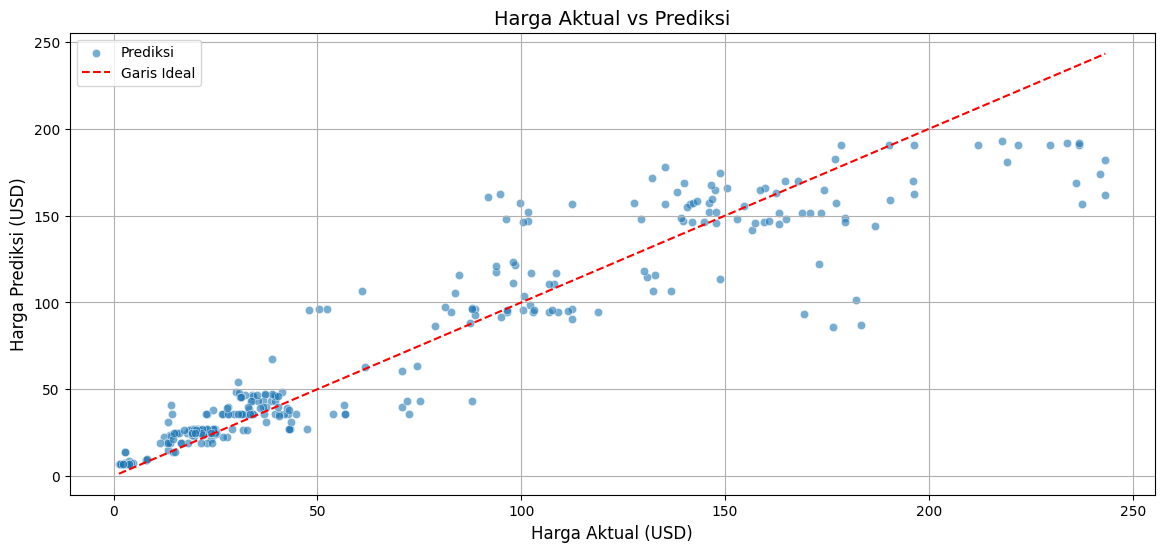

In [59]:
plt.figure(figsize=(14, 6))
sns.scatterplot(x=comparison_df['Aktual'], y=comparison_df['Prediksi'], alpha=0.6, label='Prediksi')
plt.plot([comparison_df['Aktual'].min(), comparison_df['Aktual'].max()],
         [comparison_df['Aktual'].min(), comparison_df['Aktual'].max()],
         color='red', linestyle='--', label='Garis Ideal')
plt.title('Harga Aktual vs Prediksi', fontsize=14)
plt.xlabel('Harga Aktual (USD)', fontsize=12)
plt.ylabel('Harga Prediksi (USD)', fontsize=12)
plt.grid()
plt.legend(loc='upper left')
plt.show()

Dari visualiasi di atas didapatkan informasi sebagai berikut:

Meskipun ada beberapa titik data yang melenceng dari garis ideal, tetapi secara keseluruhan sebaran titik-titik pada grafik harga aktual vs harga prediksi menunjukkan bahwa prediksi model XGBoost cukup akurat dan mengikuti tren harga aktual dengan baik.

Namun, perlu diingat bahwa model tetap memiliki keterbatasan dan prediksi harga Solana di dunia nyata dipengaruhi oleh banyak faktor kompleks yang mungkin tidak sepenuhnya tercakup dalam model, seperti sentimen pasar, Naratif dari pasar, dan berita terkait Solana.

##**Prediksi Harga 10 Hari ke Depan**##

In [74]:
last_features = shifted_df[['High_shifted', 'Low_shifted', 'Open_shifted', 'Price_shifted']].iloc[-10:]
last_features_scaled = scaler_X.transform(last_features)

pred_xgb_scaled = xgb_best_model.predict(last_features_scaled)
pred_xgb = scaler_y.inverse_transform(pred_xgb_scaled.reshape(-1, 1))

last_date = pd.to_datetime('2024-12-7')

predicted_dates = [last_date + pd.Timedelta(days=i) for i in range(1, 11)]

predictions_df = pd.DataFrame({
    'Date': predicted_dates,
    'Predicted (XGBoost)': pred_xgb.flatten()
})

In [75]:
predictions_df

,Date,Predicted (XGBoost)
0,2024-12-08,190.149109
1,2024-12-09,182.193359
2,2024-12-10,193.662140
3,2024-12-11,191.563919
4,2024-12-12,190.703537
5,2024-12-13,191.671692
6,2024-12-14,191.379044
7,2024-12-15,191.563919
8,2024-12-16,190.703537
9,2024-12-17,191.171753
